In [10]:
import pandas as pd
import importlib
import mpt_functions as mpt
importlib.reload(mpt)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score



f1_start = "2020-04-18 00:00:00"
f1_finish = "2020-04-18 23:59:00"
f2_start = "2020-05-29 23:30:00"
f2_finish = "2020-05-30 06:00:00"
f3_start = "2020-06-05 10:00:00"
f3_finish = "2020-06-07 14:30:00"
f4_start = "2020-07-15 14:30:00"
f4_finish = "2020-07-15 19:00:00"

# **************************************************************************************************************#

path = "/Users/abdullahfurkanarslan/Desktop/metropt+3+dataset 2/MetroPT3(AirCompressor).csv"
df = mpt.get_the_data_and_convert_datetime(path)

#

df = mpt.drop_a_column(df, "Unnamed: 0")

#

df = df.assign(condition=0)
df = mpt.change_the_values_by_applying_a_time_filter(df, f1_start, f1_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f2_start, f2_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f3_start, f3_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f4_start, f4_finish, "condition", 1)




#

all_column_names = df.columns.to_list()

name_of_the_categorical_columns = ['COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

name_of_the_numerical_columns =['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current']

target_column = df["condition"]

#

df_scaled = mpt.scale_columns(df, name_of_the_numerical_columns)




datetime_column = df.columns[0]  # Adjust this if your datetime column isn't the first one

# Add month and week number columns
df_scaled['number_of_the_month'] = df_scaled[datetime_column].dt.month
df_scaled['number_of_the_week'] = df_scaled[datetime_column].dt.isocalendar().week
df_scaled["number_of_the_day"] = df_scaled[datetime_column].dt.isocalendar().day


df_scaled['number_of_the_month'] = df_scaled['number_of_the_month'].astype('float64')
df_scaled['number_of_the_week'] = (df_scaled['number_of_the_week'].astype('float64') % 4) + 1
df_scaled['number_of_the_day'] = df_scaled['number_of_the_day'].astype('float64')




def aggregate(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8):
    

    result1 = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")

    probabilities = result1[0]
    y_test = result1[1]

    #probabilities = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")[0]
    #y_test = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "no")[1]
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition(df_ed, aggregation_size)
    return result


def agg_new_deneme(penalty, C_value, solver, max_iter, df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):

    result1 = mpt.get_the_probabilities_with_logistic_regressionn_new(penalty, C_value, solver, max_iter,df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)

    probabilities = result1[0]
    y_test = result1[1]

    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result


def agg_random_forest(n, f, d, s, l, df, aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount, graph):


    result1 = mpt.get_the_probabilities_with_random_forest_new_new(n, f, d, s, l, df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4, graph)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)

    feature_importances = result1[2]

    return result, feature_importances, y_test


def agg_single_tree(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):


    result1 = mpt.get_the_probabilities_with_single_tree(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result



def plot_probabilities_by_condition(df, threshold): # tekrar yazılacak

    print(1)
    print(df)

    indices = np.arange(df.shape[0])
    
    # Create figure
    plt.figure(figsize=(8, 5))
    
    # Plot points with condition=0 and proba <= threshold in blue
    mask_0_below = (df['condition'] == 0) & (df['proba'] <= threshold)
    plt.scatter(indices[mask_0_below], df.loc[mask_0_below, 'proba'], 
                color='blue', alpha=0.7, label='condition=0')
    
    # Plot points with condition=0 and proba > threshold in red
    mask_0_above = (df['condition'] == 0) & (df['proba'] > threshold)
    plt.scatter(indices[mask_0_above], df.loc[mask_0_above, 'proba'], 
                color='red', alpha=0.7, label=f'condition=0, proba>{threshold}')
    
    # Plot points with condition=1 in black
    mask_1 = df['condition'] == 1
    plt.scatter(indices[mask_1], df.loc[mask_1, 'proba'], 
                color='black', alpha=0.7, label='condition=1')

    
    # Add labels and title
    plt.title('Probablity of Failure')
    plt.xlabel('Index')
    plt.ylabel('Probability')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()


df_back_up = df_scaled.copy()

                     Importance
DV_pressure            0.897749
number_of_the_day      0.073745
Oil_temperature        0.026597
H1                     0.001785
Reservoirs             0.000124
Motor_current          0.000000
number_of_the_month    0.000000
R-squareddd: 0.993468795293106
F-Value Like: 2180295.4551952416
model preditions
[0 0 0 ... 0 0 0]
model proba
[1.56715616e-04 1.56715616e-04 1.56715616e-04 ... 8.08396545e-06
 8.08396545e-06 8.08396545e-06]
        model_predictions  model_probablities
0                       0            0.000157
1                       0            0.000157
2                       0            0.000157
3                       0            0.000157
4                       0            0.000157
...                   ...                 ...
161090                  0            0.000008
161091                  0            0.000008
161092                  0            0.000008
161093                  0            0.000008
161094                  0     

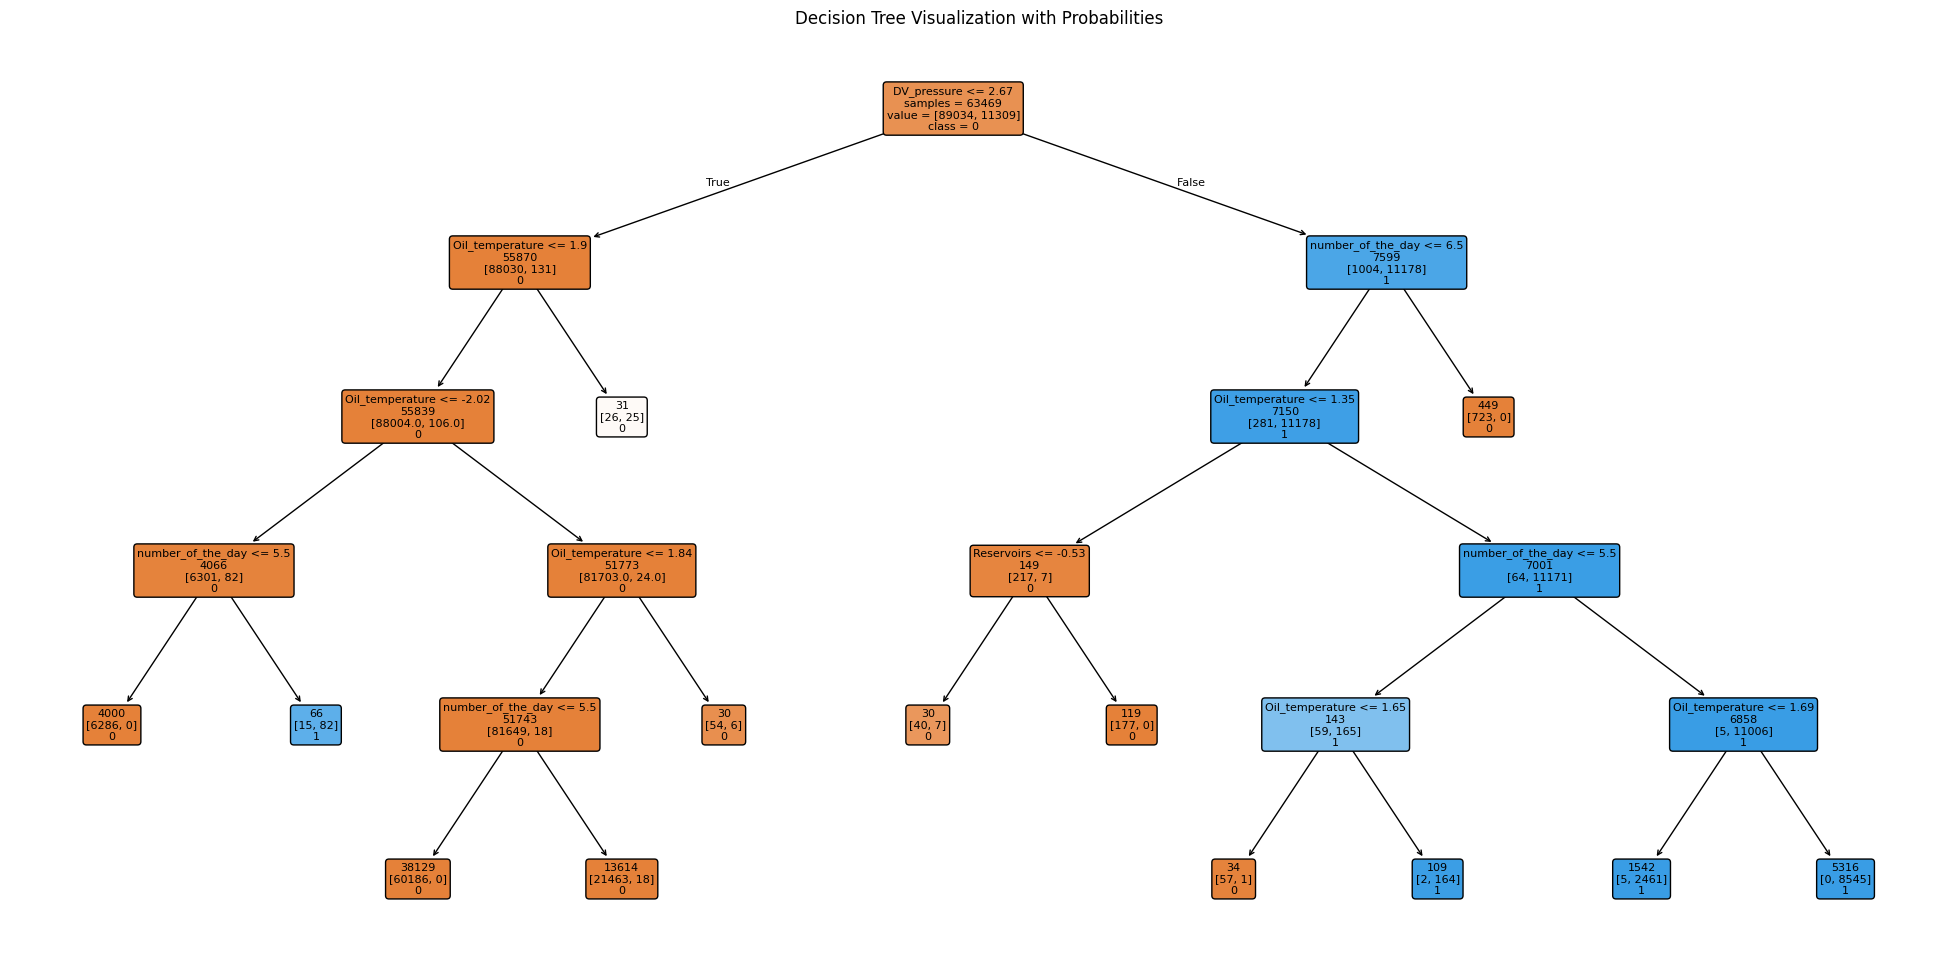

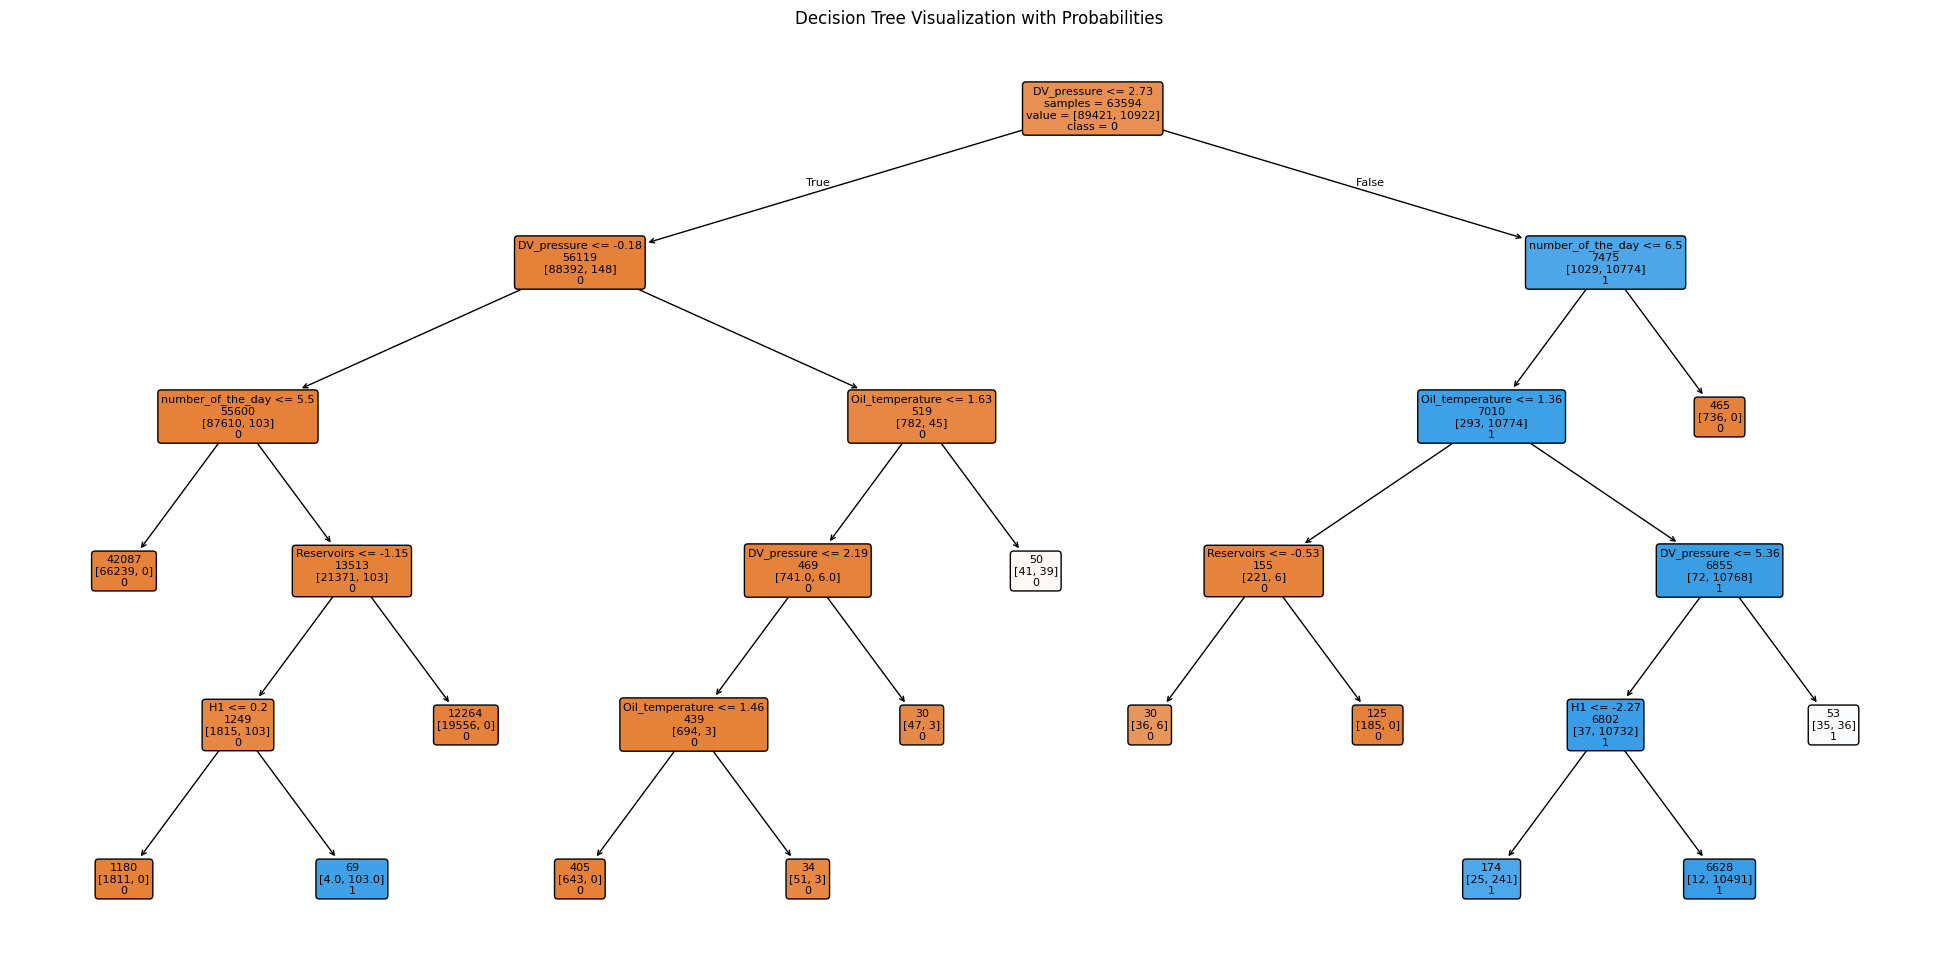

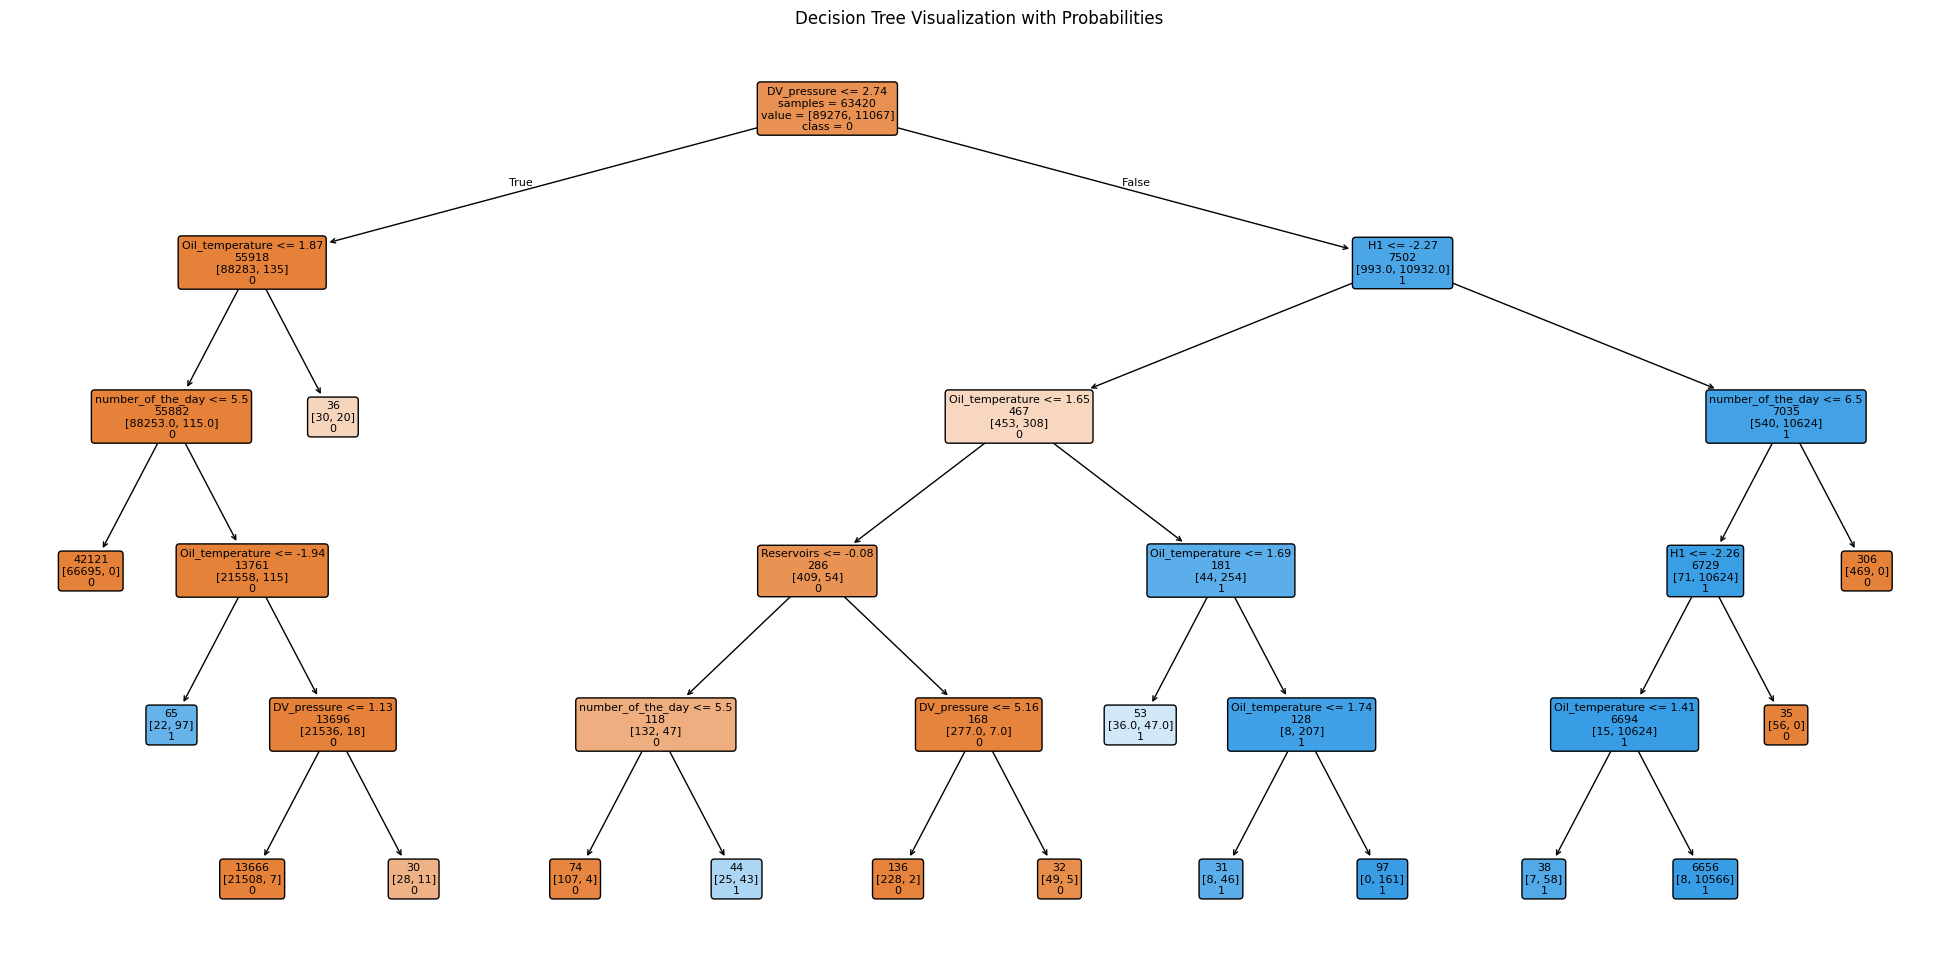

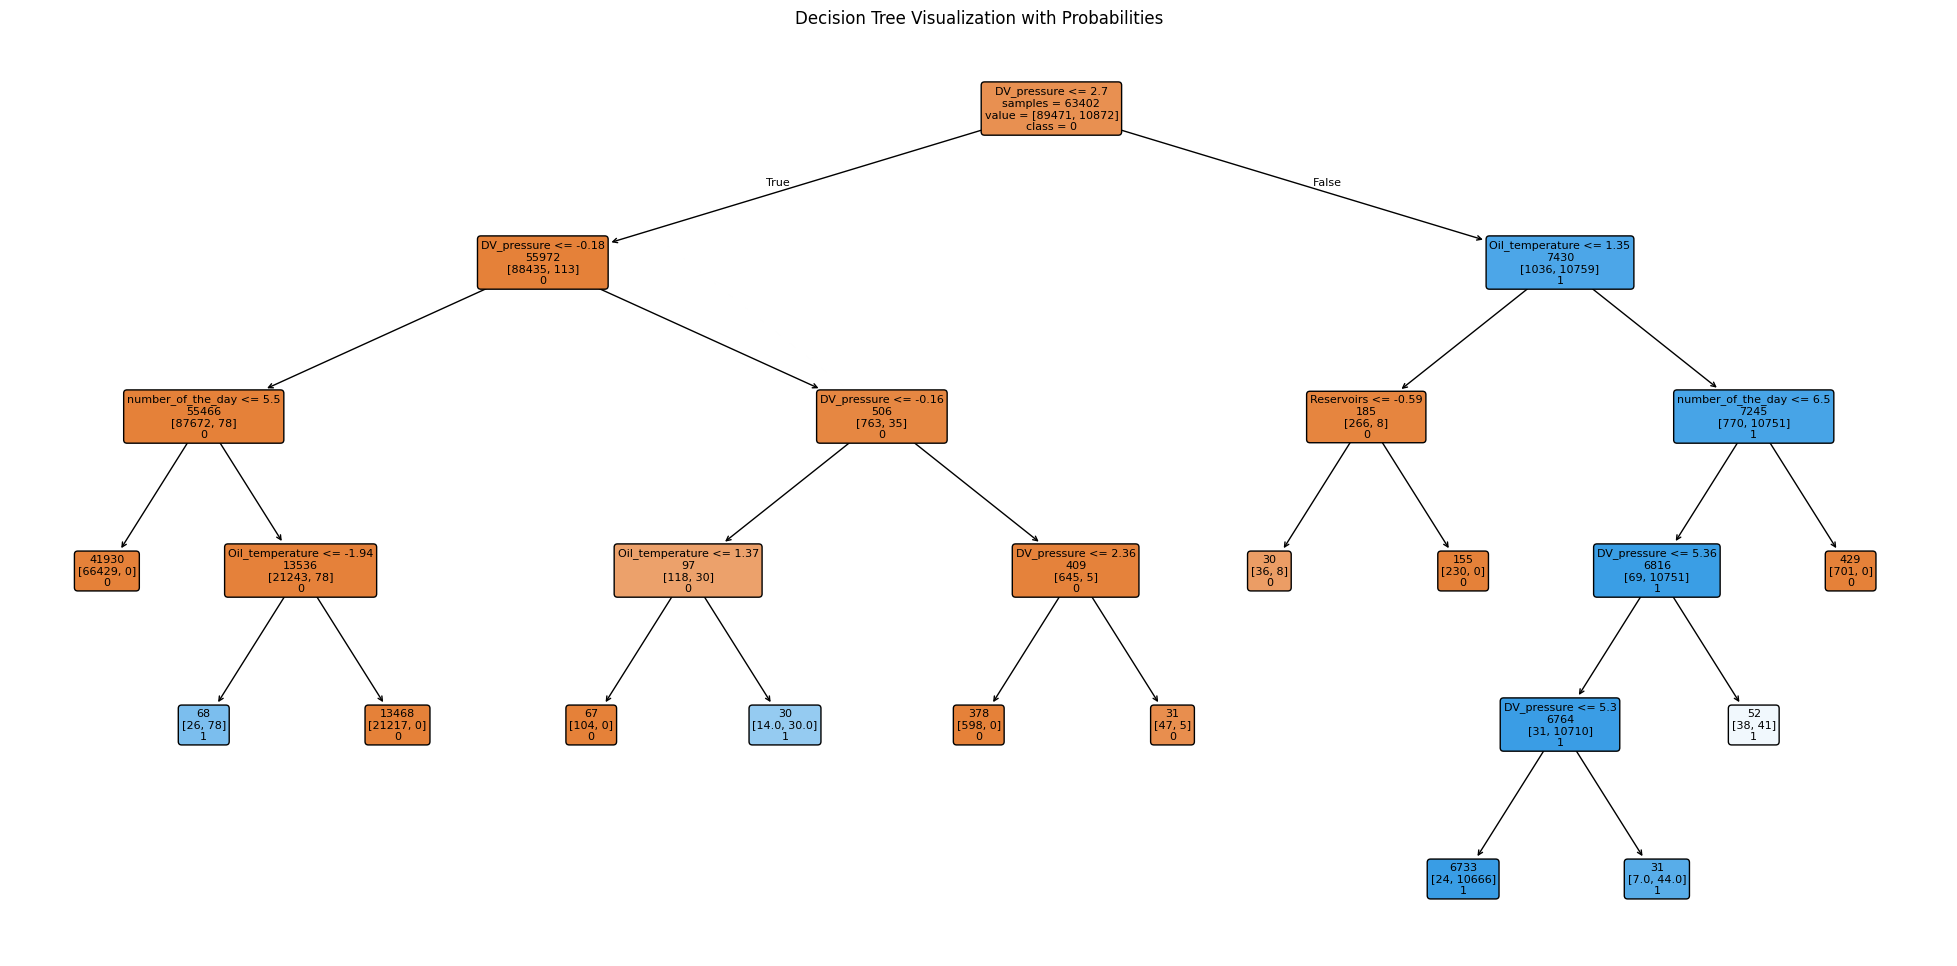

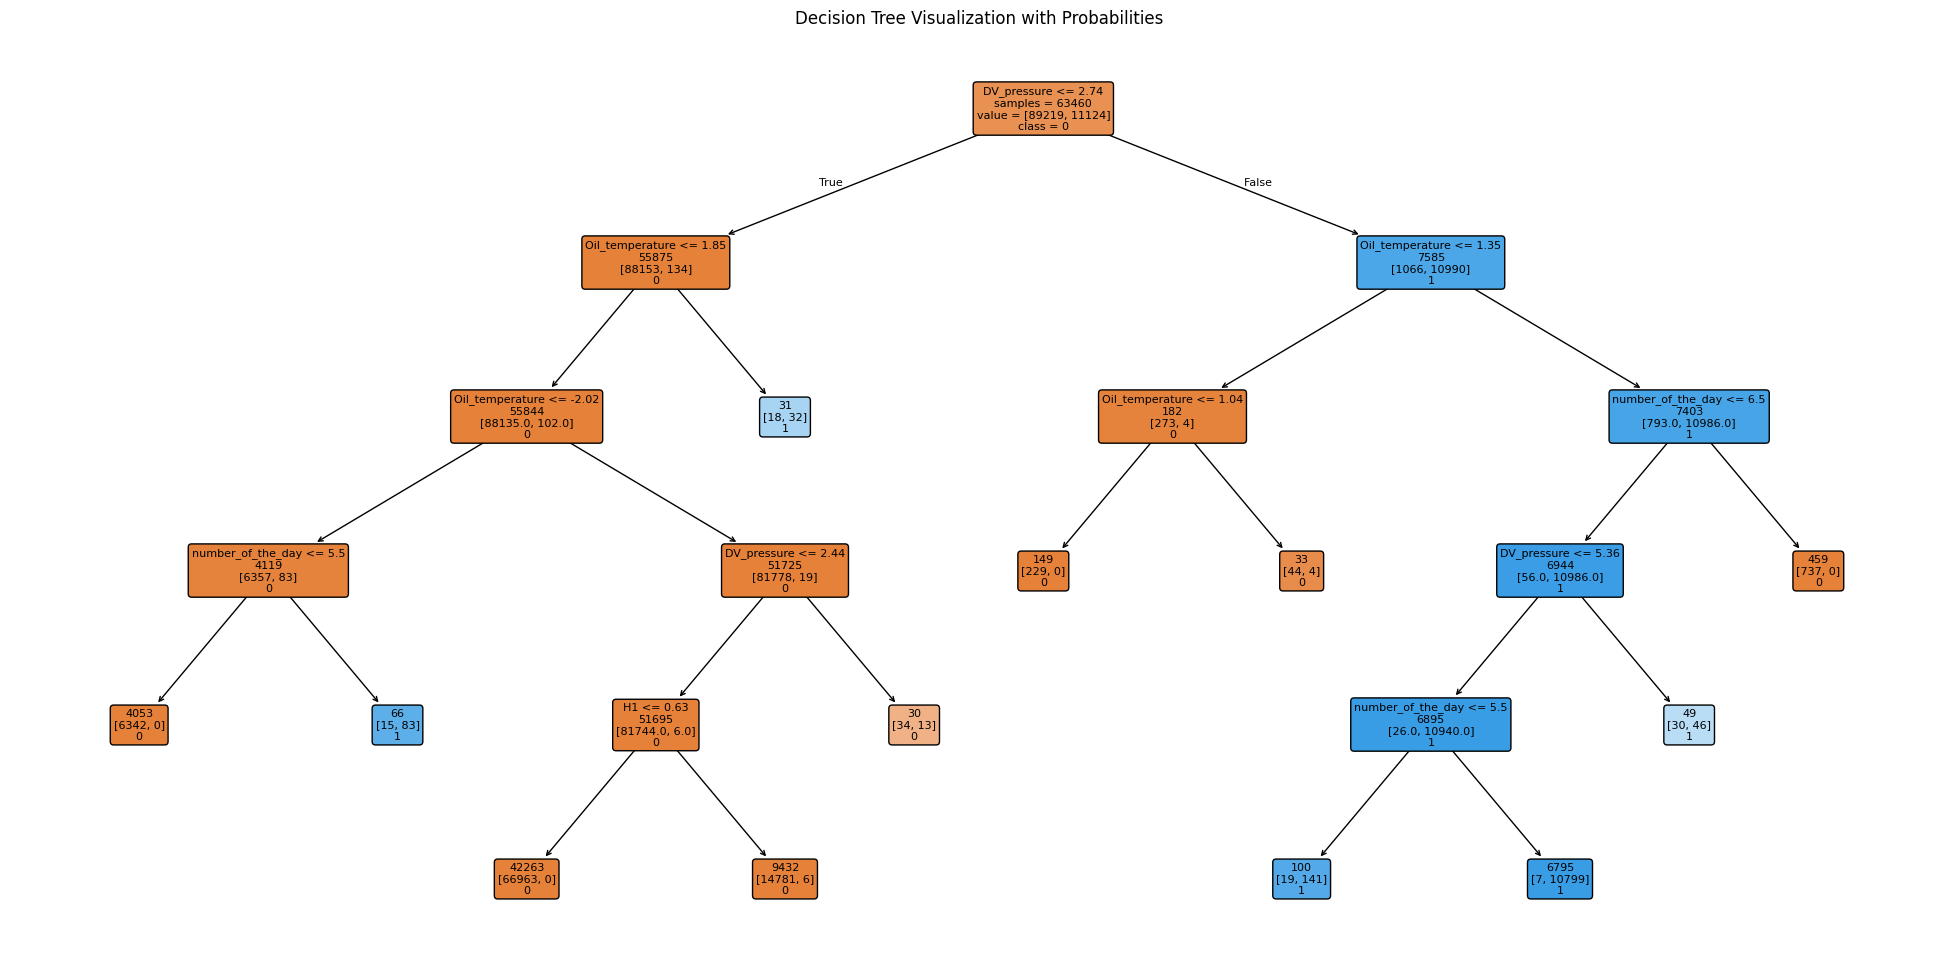

1
      group_id  start_row  end_row  row_count     proba  condition
0            0          0      399        400  0.000232          0
1            1        100      499        400  0.000236          0
2            2        200      599        400  0.000239          0
3            3        300      699        400  0.000240          0
4            4        400      799        400  0.000185          0
...        ...        ...      ...        ...       ...        ...
1603      1603     160300   160699        400  0.025044          0
1604      1604     160400   160799        400  0.028039          0
1605      1605     160500   160899        400  0.025815          0
1606      1606     160600   160999        400  0.023056          0
1607      1607     160700   161094        395  0.019077          0

[1608 rows x 6 columns]


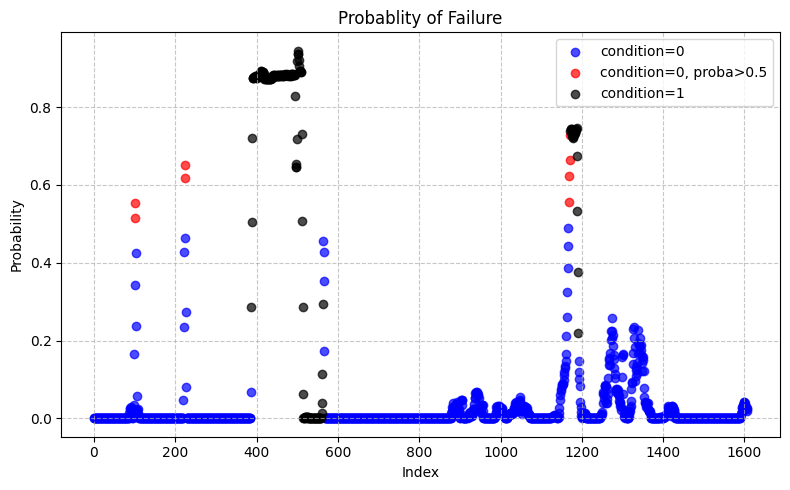

In [11]:
dataframe = df_back_up.copy()


dataframe = dataframe.drop(labels = [
    "DV_eletric", 
    "TP2",   
    "MPG", 
    "LPS", 
    "Pressure_switch", 
    "Oil_level", 
    "Caudal_impulses", 
    "number_of_the_week",
    "Towers",
    "TP3",
    "COMP",
], axis = 1)



def fit_the_model(i, j, k, l):
    
    aggregation_size = 400

    treshold_probability = 0.5

    aggregated_probabilities, f1, a = agg_random_forest(i, 5, j, k, l, dataframe, aggregation_size, 4, 2, 4, 2, 5, 5, 5, 5, "yes", "yes", "no", "no", 100, "yes")

    plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

    return aggregated_probabilities


aggregated_probabilities = fit_the_model(5, 5, 60, 30)

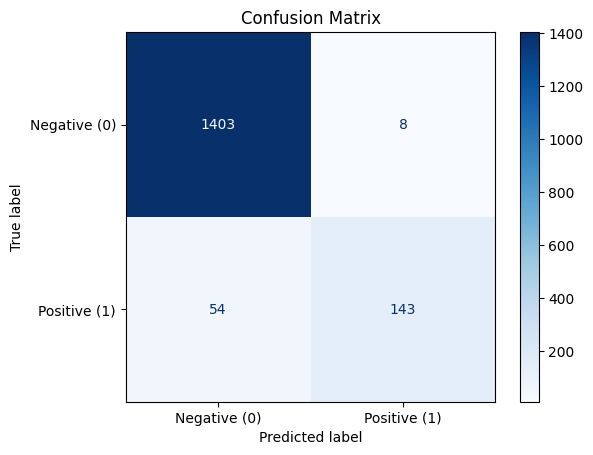

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1411
           1       0.95      0.73      0.82       197

    accuracy                           0.96      1608
   macro avg       0.95      0.86      0.90      1608
weighted avg       0.96      0.96      0.96      1608



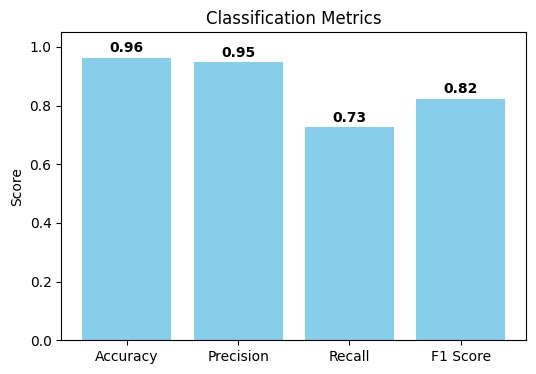

In [12]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt

# Tahmin sütunu oluştur
aggregated_probabilities['predicted'] = (aggregated_probabilities['proba'] >= 0.5).astype(int)

# Gerçek ve tahmin değerleri
y_true = aggregated_probabilities['condition']
y_pred = aggregated_probabilities['predicted']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative (0)", "Positive (1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Metrikleri hesapla
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Metrikleri yazdır
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=2, zero_division=0))

# Bar grafiği ile görselleştir
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

plt.figure(figsize=(6, 4))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0, 1.05)
plt.title("Classification Metrics")
plt.ylabel("Score")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()



                     Importance
DV_pressure            0.897749
number_of_the_day      0.073745
Oil_temperature        0.026597
H1                     0.001785
Reservoirs             0.000124
Motor_current          0.000000
number_of_the_month    0.000000
R-squareddd: 0.993468795293106
F-Value Like: 2180295.4551952416
model preditions
[0 0 0 ... 0 0 0]
model proba
[0.00015672 0.00015672 0.00015672 ... 0.00015672 0.00015672 0.00015672]
        model_predictions  model_probablities
0                       0            0.000157
1                       0            0.000157
2                       0            0.000157
3                       0            0.000157
4                       0            0.000157
...                   ...                 ...
444443                  0            0.000157
444444                  0            0.000157
444445                  0            0.000157
444446                  0            0.000157
444447                  0            0.000157

[444448 

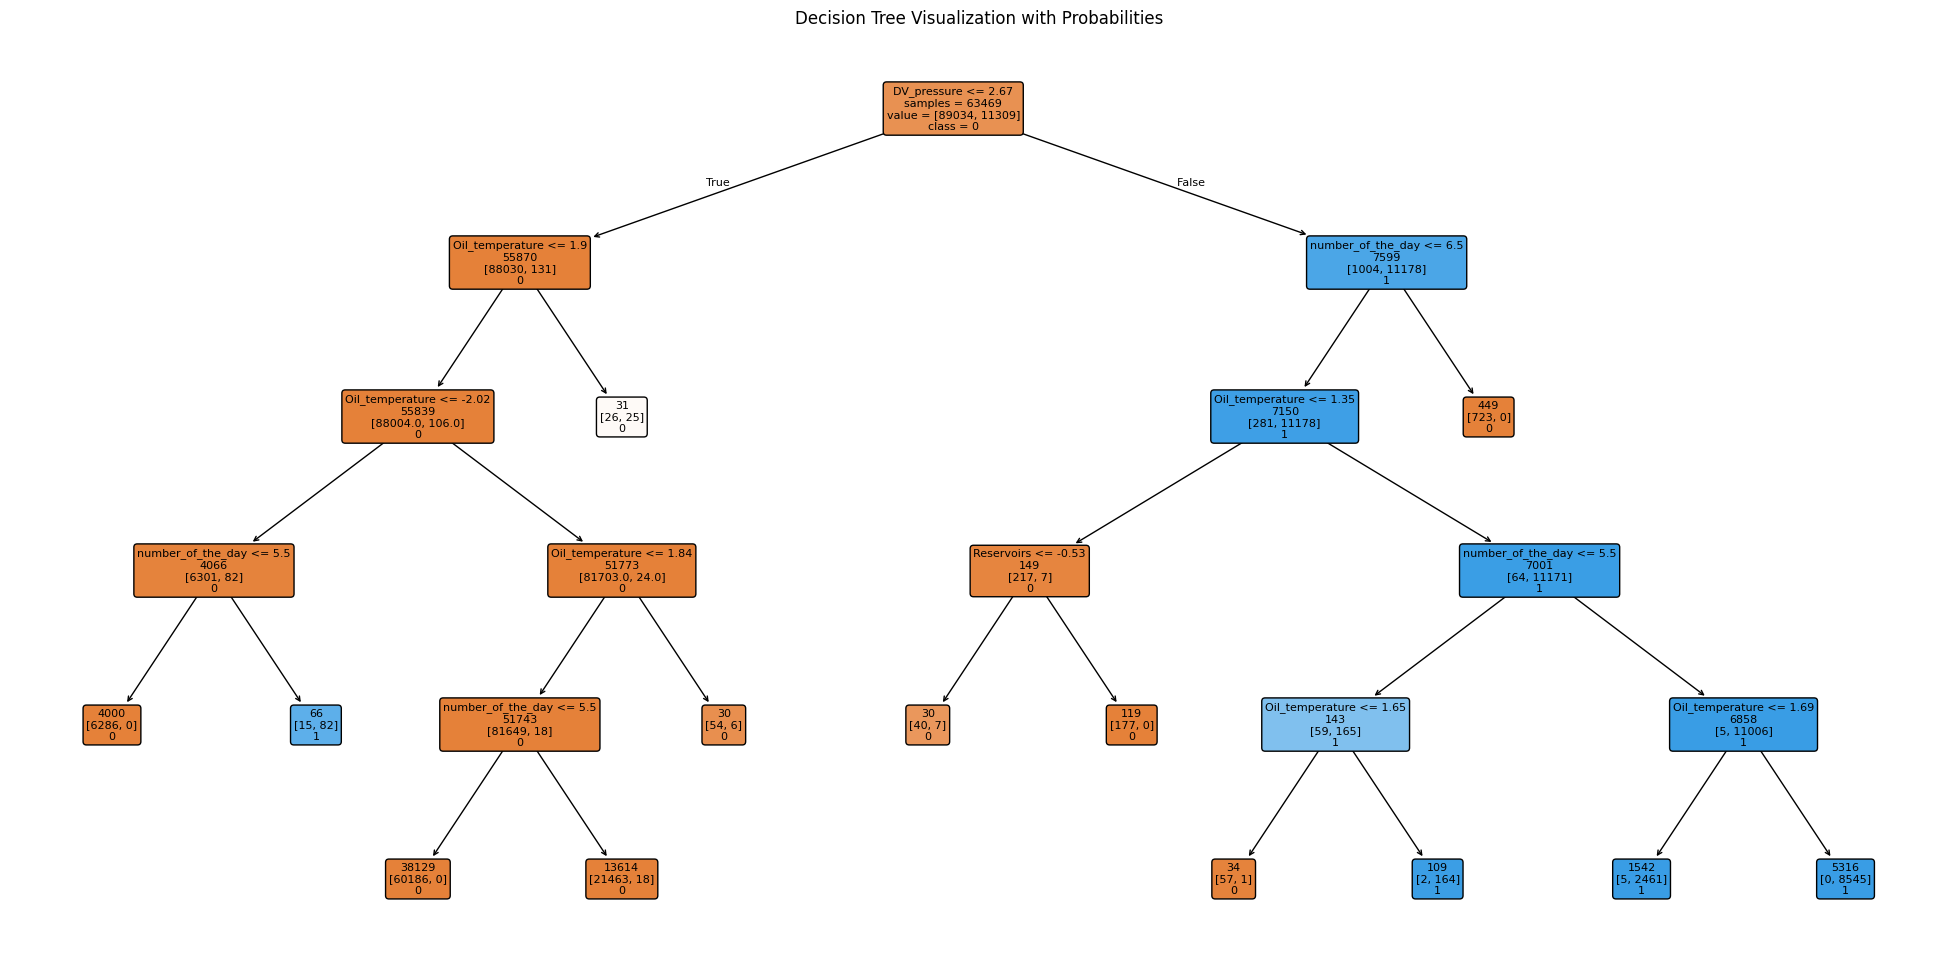

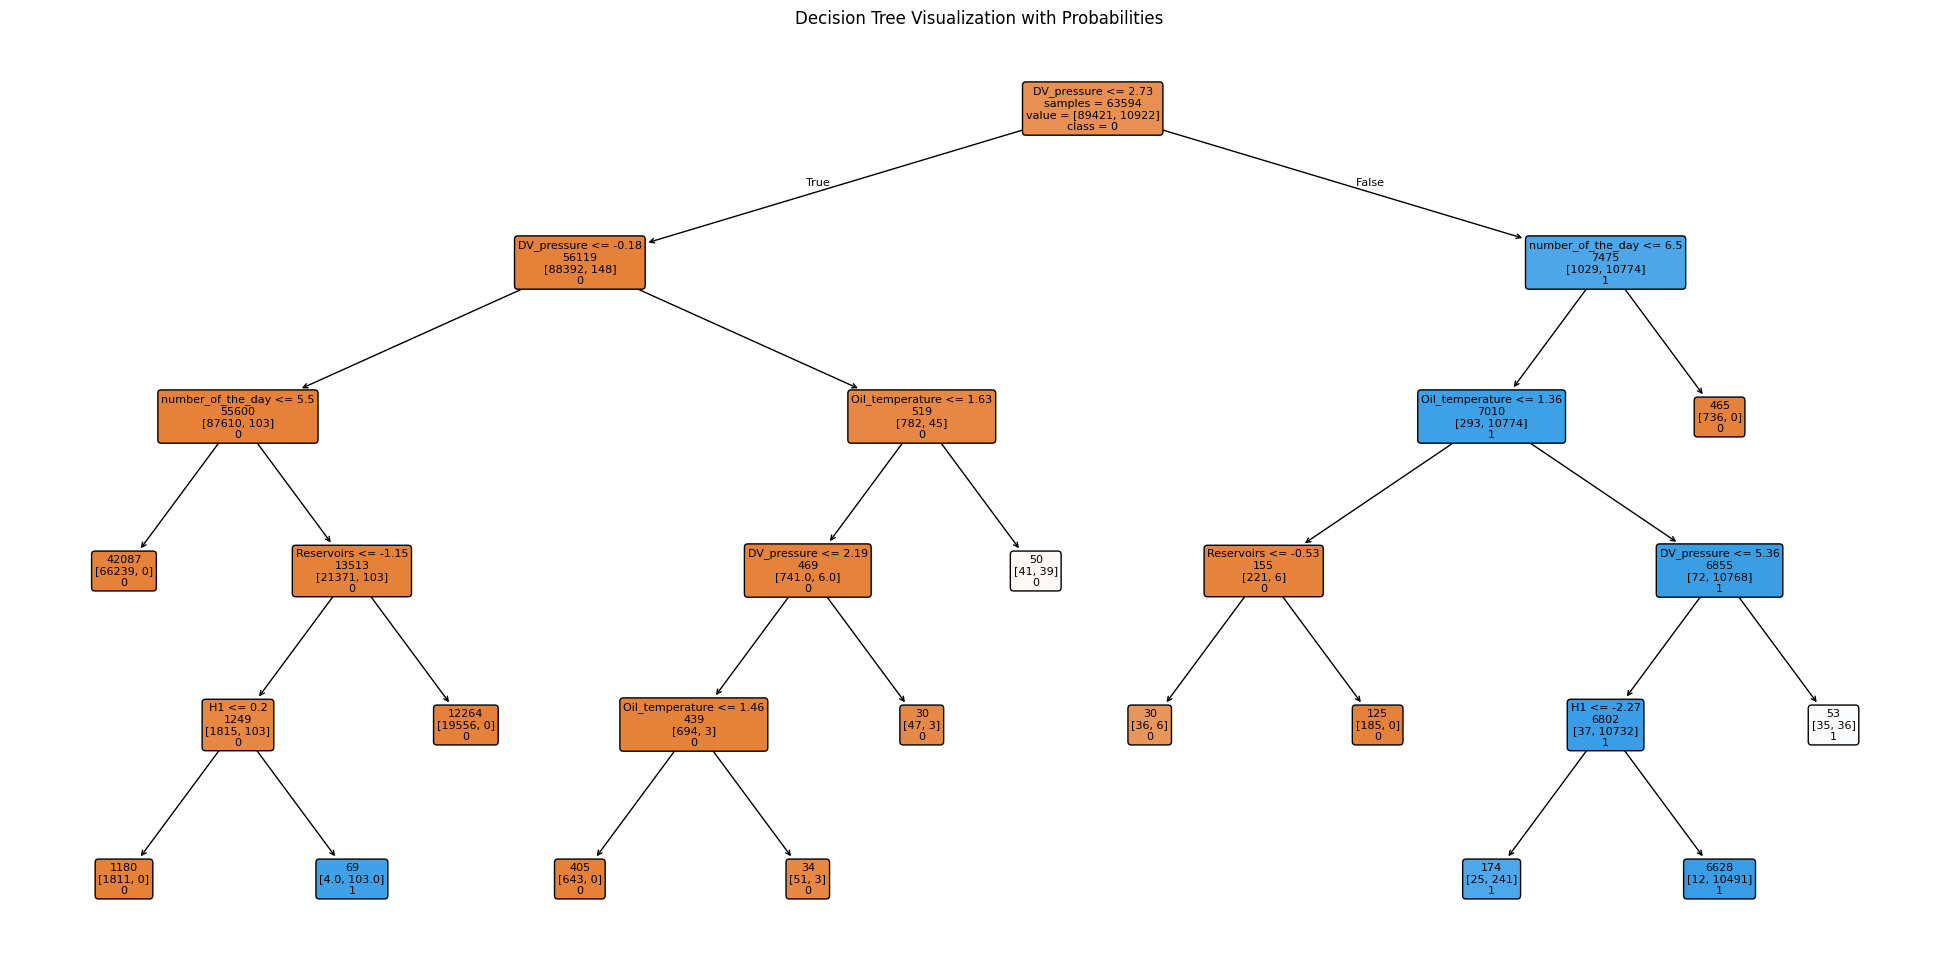

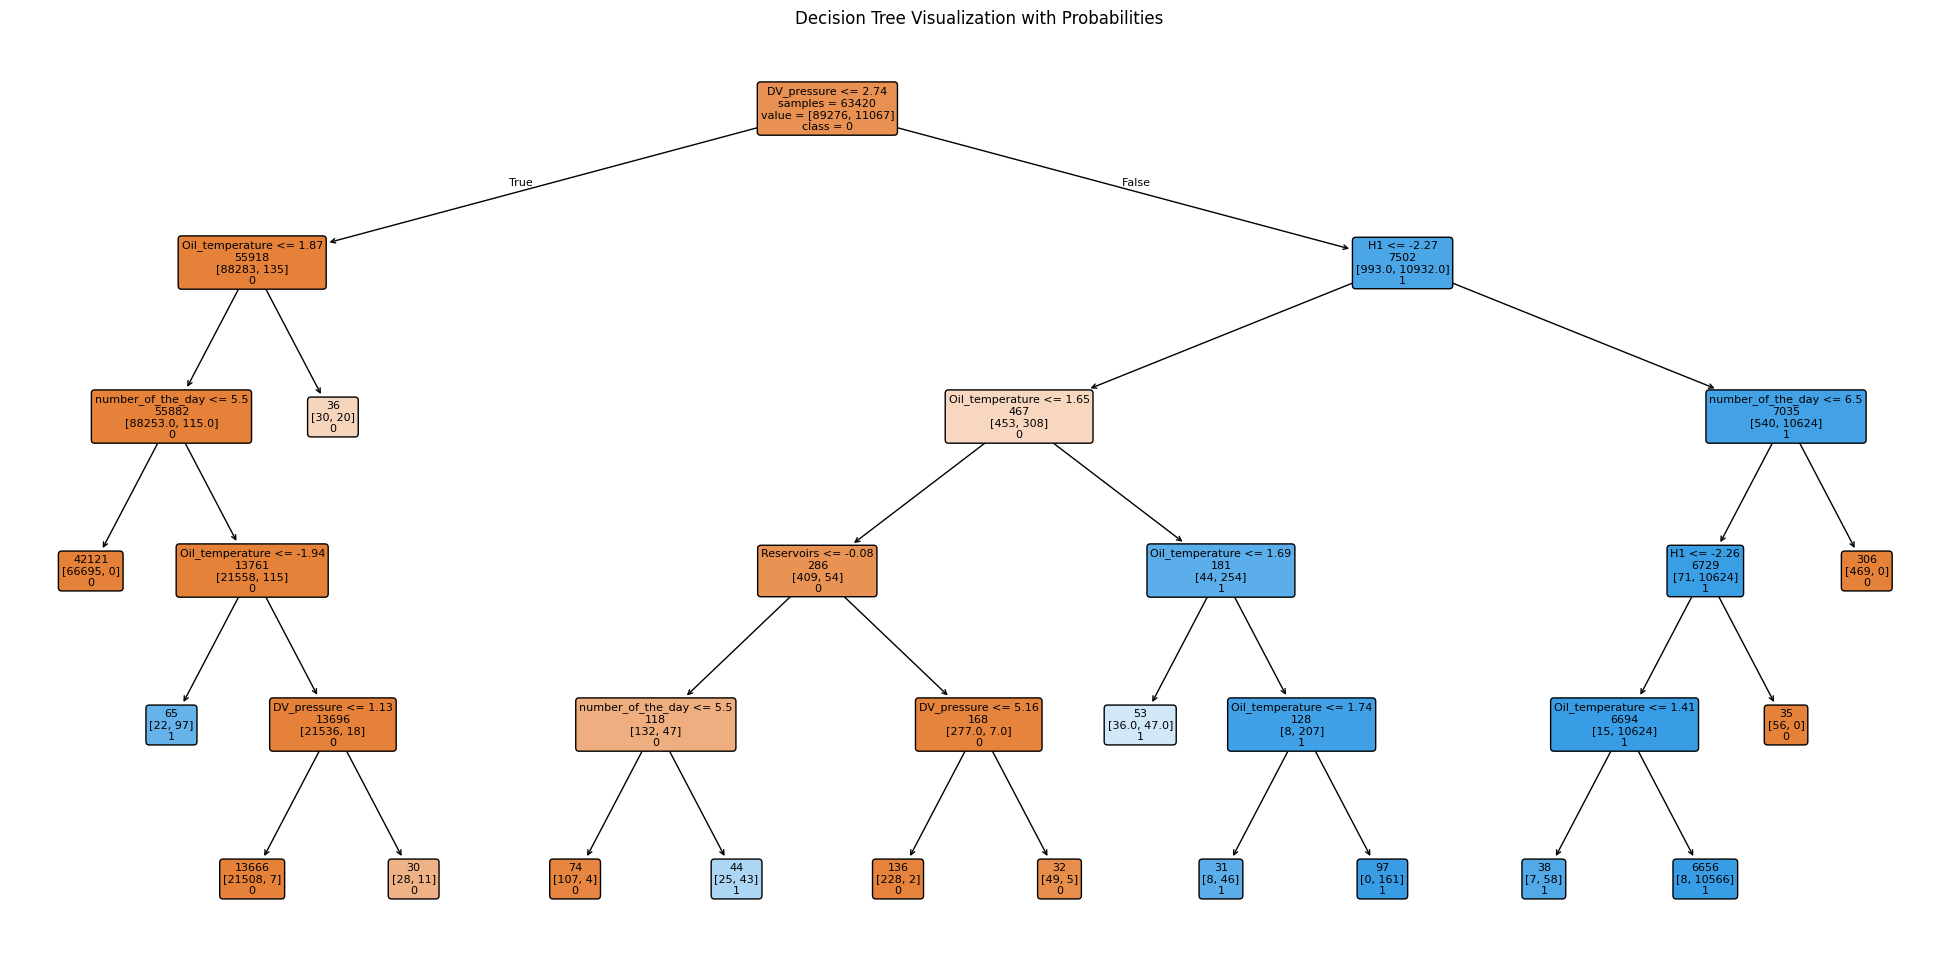

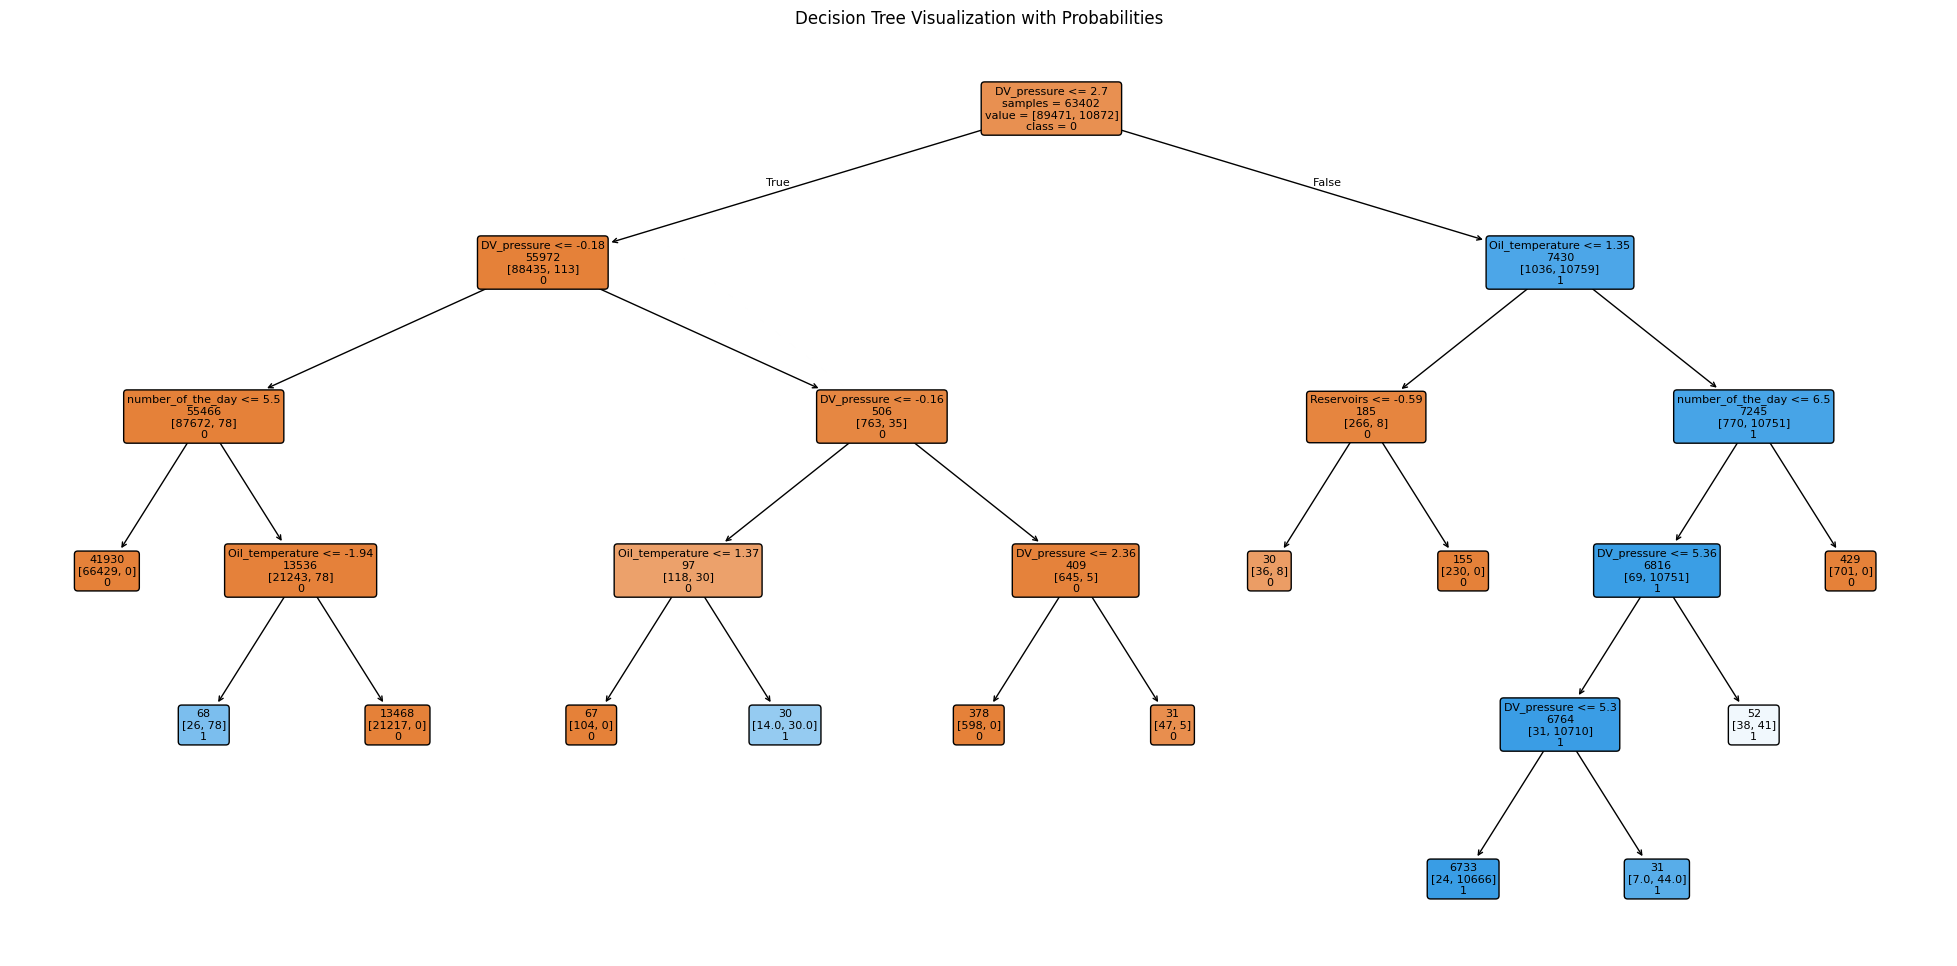

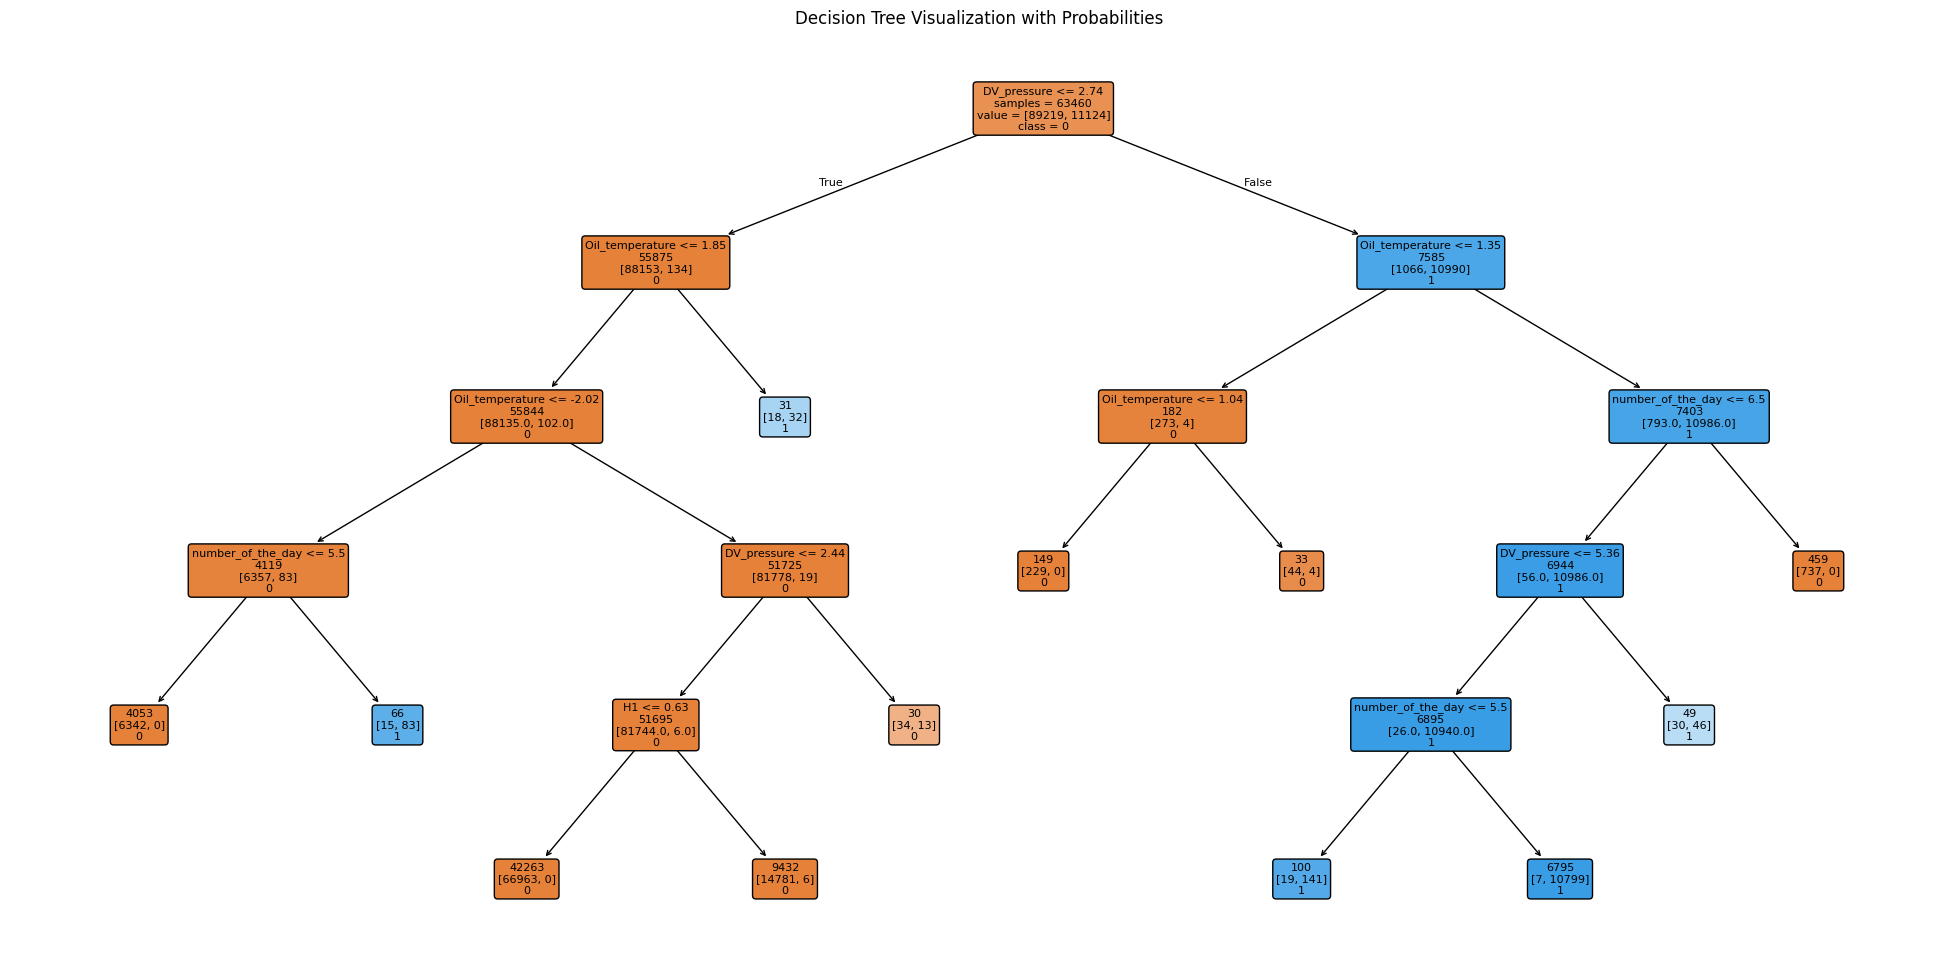

1
      group_id  start_row  end_row  row_count     proba  condition
0            0          0      399        400  0.000232          0
1            1        100      499        400  0.000236          0
2            2        200      599        400  0.000239          0
3            3        300      699        400  0.000240          0
4            4        400      799        400  0.000185          0
...        ...        ...      ...        ...       ...        ...
4437      4437     443700   444099        400  0.000270          0
4438      4438     443800   444199        400  0.000269          0
4439      4439     443900   444299        400  0.000673          0
4440      4440     444000   444399        400  0.000752          0
4441      4441     444100   444447        348  0.000833          0

[4442 rows x 6 columns]


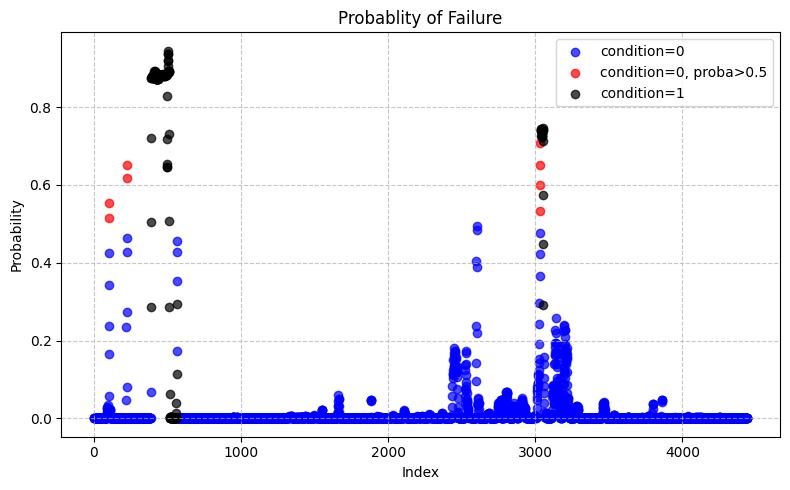

In [13]:
dataframe = df_back_up.copy()


dataframe = dataframe.drop(labels = [
    "DV_eletric", 
    "TP2",   
    "MPG", 
    "LPS", 
    "Pressure_switch", 
    "Oil_level", 
    "Caudal_impulses", 
    "number_of_the_week",
    "Towers",
    "TP3",
    "COMP",
], axis = 1)



def fit_the_model(i, j, k, l):
    
    aggregation_size = 400

    treshold_probability = 0.5

    aggregated_probabilities, f1, a = agg_random_forest(i, 5, j, k, l, dataframe, aggregation_size, 4, 2, 4, 2, 5, 18, 18, 18, "yes", "yes", "no", "no", 100, "yes")

    plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

    return aggregated_probabilities


aggregated_probabilities= fit_the_model(5, 5, 60, 30)

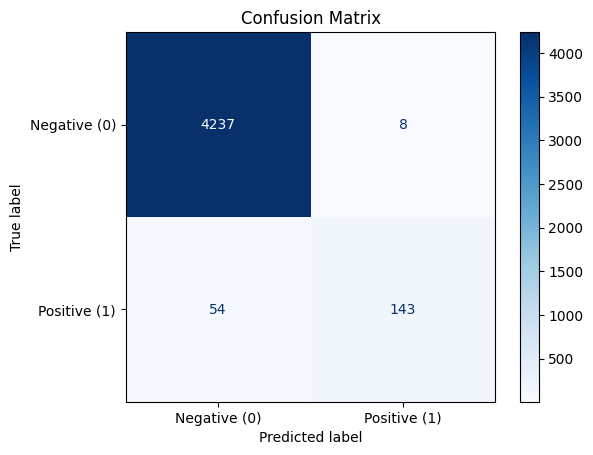

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4245
           1       0.95      0.73      0.82       197

    accuracy                           0.99      4442
   macro avg       0.97      0.86      0.91      4442
weighted avg       0.99      0.99      0.99      4442



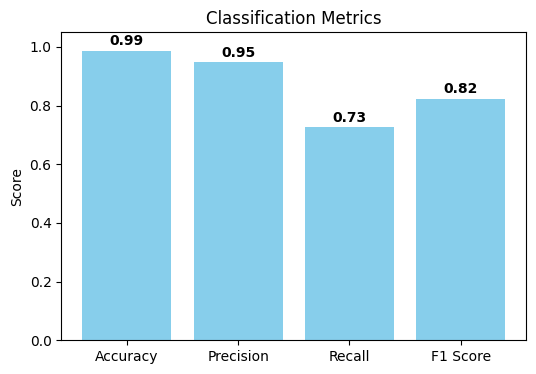

In [14]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt

# Tahmin sütunu oluştur
aggregated_probabilities['predicted'] = (aggregated_probabilities['proba'] >= 0.5).astype(int)

# Gerçek ve tahmin değerleri
y_true = aggregated_probabilities['condition']
y_pred = aggregated_probabilities['predicted']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative (0)", "Positive (1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Metrikleri hesapla
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Metrikleri yazdır
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=2, zero_division=0))

# Bar grafiği ile görselleştir
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

plt.figure(figsize=(6, 4))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0, 1.05)
plt.title("Classification Metrics")
plt.ylabel("Score")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()



Logistic Regression

In [15]:
f1_start = "2020-04-18 00:00:00"
f1_finish = "2020-04-18 23:59:00"
f2_start = "2020-05-29 23:30:00"
f2_finish = "2020-05-30 06:00:00"
f3_start = "2020-06-05 10:00:00"
f3_finish = "2020-06-07 14:30:00"
f4_start = "2020-07-15 14:30:00"
f4_finish = "2020-07-15 19:00:00"

# **************************************************************************************************************#

path = "/Users/abdullahfurkanarslan/Desktop/metropt+3+dataset 2/MetroPT3(AirCompressor).csv"
df = mpt.get_the_data_and_convert_datetime(path)

#

df = mpt.drop_a_column(df, "Unnamed: 0")

#

df = df.assign(condition=0)
df = mpt.change_the_values_by_applying_a_time_filter(df, f1_start, f1_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f2_start, f2_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f3_start, f3_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f4_start, f4_finish, "condition", 1)

# optional 1

df["data_point_number"] = df.index + 1

# optional 2

df  = mpt.counter_for_maintenance(df , "2020-02-01 00:00:00", f1_finish)
df  = mpt.counter_for_maintenance(df , f1_finish, f2_finish)
df  = mpt.counter_for_maintenance(df , f2_finish, f3_finish)
df  = mpt.counter_for_maintenance(df , f3_finish, f4_finish)
df = mpt.counter_for_maintenance(df, f4_finish, "2020-09-01 03:59:51")

#

all_column_names = df.columns.to_list()

name_of_the_categorical_columns = ['COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

name_of_the_numerical_columns =["counter",'data_point_number','TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current']

target_column = df["condition"]

#

df_scaled = mpt.scale_columns(df, name_of_the_numerical_columns)

# optional 3

df_clustered = mpt.apply_kmeans_clustering(df_scaled, 5, "condition")

In [16]:
df2 = df_clustered.drop(labels = ["Cluster"], axis = 1)  # OK but not suspicious

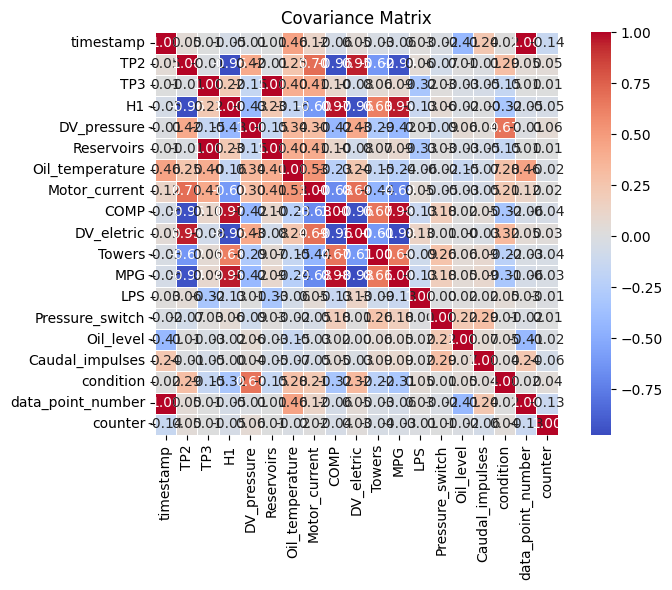

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Kovaryans matrisi
cov_matrix = df2.corr()

# Heatmap ile görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Covariance Matrix")
plt.tight_layout()
plt.show()


In [42]:
df3 = df2.drop(labels=["TP3", "COMP", "H1", "DV_eletric", "TP2", "timestamp", "Caudal_impulses", "Pressure_switch", "Oil_level", ], axis=1)

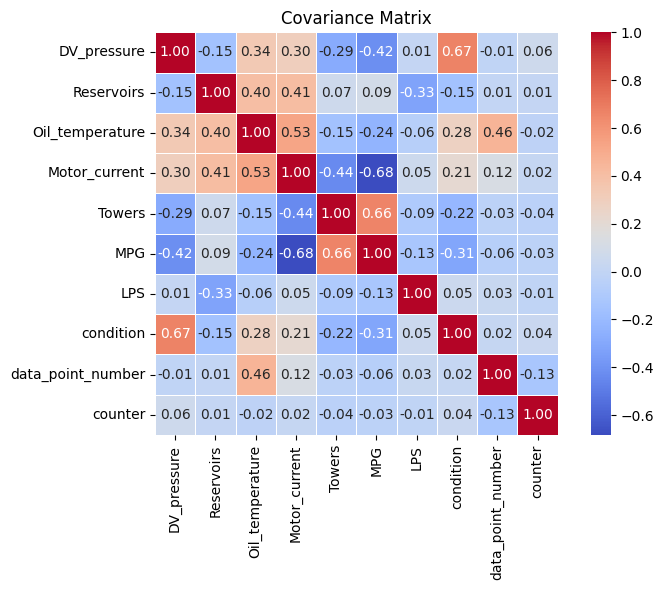

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Kovaryans matrisi
cov_matrix = df3.corr()

# Heatmap ile görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Covariance Matrix")
plt.tight_layout()
plt.show()

In [17]:
def calculate_scores_log(df):
    
    # Condition değeri 1 olan satırları bul
    condition_1_rows = df[df['condition'] == 1].index.tolist()
    
    if not condition_1_rows:
        print("Condition değeri 1 olan satır bulunamadı.")
        return
    
    # Condition 1 olan grupları bul
    groups = []
    current_group = [condition_1_rows[0]]
    
    for i in range(1, len(condition_1_rows)):
        # Eğer ardışık indeksler ise aynı gruba ekle
        if condition_1_rows[i] == condition_1_rows[i-1] + 1:
            current_group.append(condition_1_rows[i])
        else:
            # Değilse yeni grup başlat
            groups.append(current_group)
            current_group = [condition_1_rows[i]]
    
    # Son grubu eklemeyi unutma
    if current_group:
        groups.append(current_group)
    
    # Early score hesaplama (her grup için ilk 1'den önceki 75 satır)
    early_score = 0
    early_rows_count = 0
    
    for group in groups:
        # Gruptaki ilk 1'in indeksi
        first_one_idx = group[0]
        # İlk 1'den önceki 75 satır (ya da mümkün olan maksimum)
        start_idx = max(0, first_one_idx - 400)
        rows_to_consider = df.iloc[start_idx:first_one_idx]

        for _, row in rows_to_consider.iterrows():
            if row['proba'] > 0.5:
                early_score += (row['proba'] - 0.45)
                early_rows_count += 1

    # False score hesaplama (condition=0 ve proba>0.4 olan yerler için)
    false_score = 0
    false_rows_count = 0
    condition_0_rows = df[df['condition'] == 0]
    
    for _, row in condition_0_rows.iterrows():
        if row['proba'] > 0.5:
            # 0.4'ü aşan kısmı topla
            false_score += (row['proba'] - 0.45)
            false_rows_count += 1


    false_score = -1*false_score + early_score
    # Sonuçları yazdır
    print(f"Early Score: {early_score:.6f} (kullanılan satır sayısı: {early_rows_count})")
    print(f"False Score: {false_score:.6f} (kullanılan satır sayısı: {false_rows_count})")
    print(early_score + false_score)
    
    return early_score, false_score

16
(17, 17)
                   Coefficient       p_value
LPS                  -3.370476  0.000000e+00
data_point_number     3.156455  0.000000e+00
counter               2.563489  0.000000e+00
Oil_temperature       2.044142  0.000000e+00
H1                   -1.184457  0.000000e+00
DV_pressure           1.157402  0.000000e+00
TP2                  -1.125472  0.000000e+00
TP3                  -0.807676  0.000000e+00
Pressure_switch       0.773087  0.000000e+00
Reservoirs           -0.732462  0.000000e+00
COMP                 -0.566423  0.000000e+00
MPG                  -0.565857  9.010974e-06
DV_eletric            0.473918  1.181277e-13
Motor_current        -0.130745  0.000000e+00
Oil_level            -0.091287  4.212453e-03
Caudal_impulses      -0.091287  4.212453e-03
Towers               -0.082336  0.000000e+00
Intercept: -7.566903410522046
R-squareddd: 0.9451849977035317
F-Value: 159933.54526626776
Early Score: 0.652746 (kullanılan satır sayısı: 4)
False Score: -0.417344 (kullanılan sa

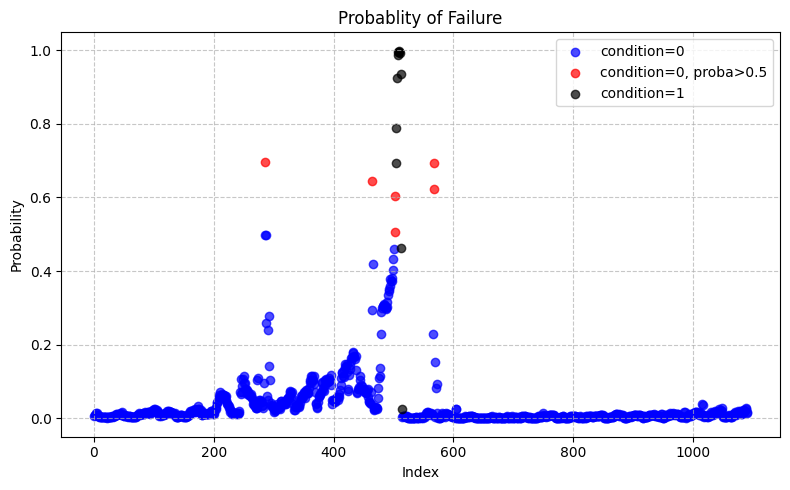

In [22]:
penalty, C_value, solver, max_iter = "l2", 0.05 , "saga", 500

aggregation_size, sliding_amount = 400,200

dataframe = df2

###########################################

treshold_probability = 0.5

aggregated_probabilities = agg_new_deneme(penalty, C_value, solver, max_iter,dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 15, 15, "yes", "yes", "yes", "no", sliding_amount)

calculate_scores_log(aggregated_probabilities)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

16
(17, 17)
                   Coefficient       p_value
data_point_number     4.497129  0.000000e+00
counter               3.448769  0.000000e+00
Oil_temperature       1.735242  0.000000e+00
LPS                  -1.379894  0.000000e+00
DV_pressure           0.906634  0.000000e+00
TP3                  -0.715332  0.000000e+00
H1                   -0.693681  0.000000e+00
Pressure_switch       0.622058  0.000000e+00
Reservoirs           -0.568404  1.854072e-13
TP2                  -0.478883  0.000000e+00
Oil_level            -0.453715  0.000000e+00
Caudal_impulses      -0.453715  0.000000e+00
COMP                 -0.400361  0.000000e+00
MPG                  -0.399436  9.805898e-06
Motor_current        -0.119123  0.000000e+00
DV_eletric           -0.055368  2.216305e-01
Towers               -0.045852  0.000000e+00
Intercept: -7.43518962215698
R-squareddd: 0.9586027131658132
F-Value: 136655.47068845085
Early Score: 2.711752 (kullanılan satır sayısı: 22)
False Score: -1.245065 (kullanılan sa

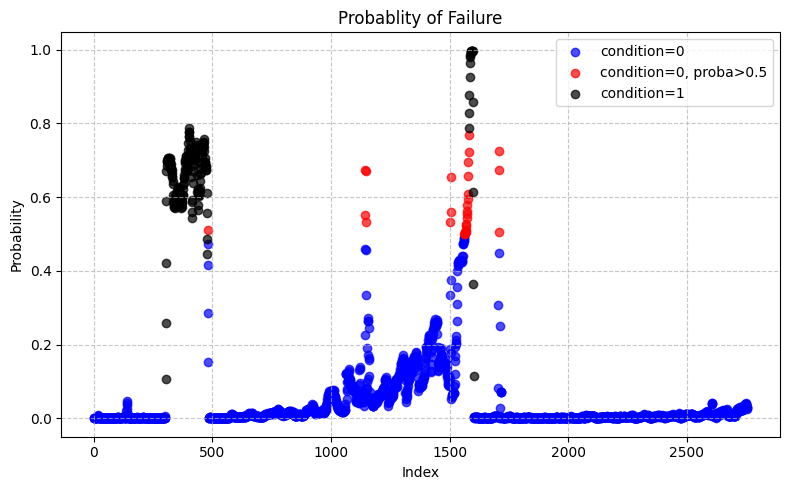

In [29]:
penalty, C_value, solver, max_iter = "l2", 0.1 , "saga", 250

aggregation_size, sliding_amount = 400,100

dataframe = df2

###########################################

treshold_probability = 0.5

aggregated_probabilities = agg_new_deneme(penalty, C_value, solver, max_iter,dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 15, 15, "yes", "yes", "no", "no", sliding_amount)

calculate_scores_log(aggregated_probabilities)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

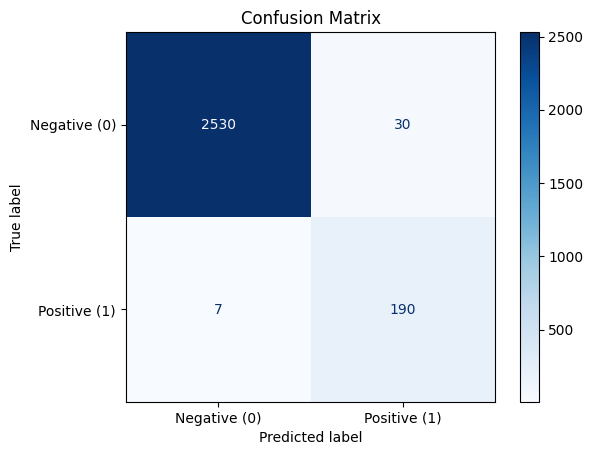

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2560
           1       0.86      0.96      0.91       197

    accuracy                           0.99      2757
   macro avg       0.93      0.98      0.95      2757
weighted avg       0.99      0.99      0.99      2757



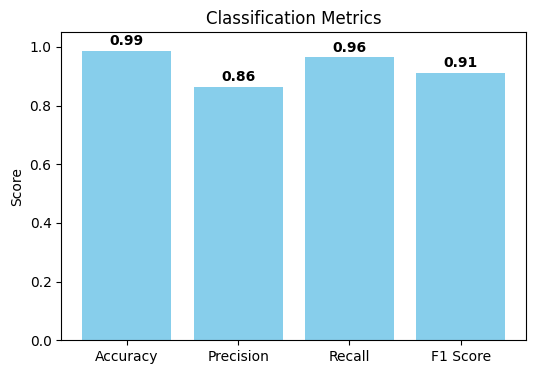

In [30]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt

# Tahmin sütunu oluştur
aggregated_probabilities['predicted'] = (aggregated_probabilities['proba'] >= 0.5).astype(int)

# Gerçek ve tahmin değerleri
y_true = aggregated_probabilities['condition']
y_pred = aggregated_probabilities['predicted']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative (0)", "Positive (1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Metrikleri hesapla
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Metrikleri yazdır
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=2, zero_division=0))

# Bar grafiği ile görselleştir
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

plt.figure(figsize=(6, 4))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0, 1.05)
plt.title("Classification Metrics")
plt.ylabel("Score")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()



In [45]:
df3 = df2.drop(labels=["TP3", "COMP", "H1", "DV_eletric", "TP2",  "Caudal_impulses", "Pressure_switch", "Oil_level", ], axis=1)

9
(9, 9)
                   Coefficient  p_value
data_point_number     4.633214      0.0
counter               3.509050      0.0
Oil_temperature       1.761903      0.0
LPS                  -1.518910      0.0
Reservoirs           -1.426182      0.0
MPG                  -1.107794      0.0
DV_pressure           0.889992      0.0
Towers               -0.087486      0.0
Motor_current        -0.034636      0.0
Intercept: -7.46317890313143
R-squareddd: 0.9583987856444626
F-Value: 256827.5065195606
Early Score: 3.787562 (kullanılan satır sayısı: 27)
False Score: -1.321396 (kullanılan satır sayısı: 34)
2.46616646586208
1
      group_id  start_row  end_row  row_count     proba  condition
0            0          0      399        400  0.000076          0
1            1        100      499        400  0.000078          0
2            2        200      599        400  0.000092          0
3            3        300      699        400  0.000056          0
4            4        400      799        40

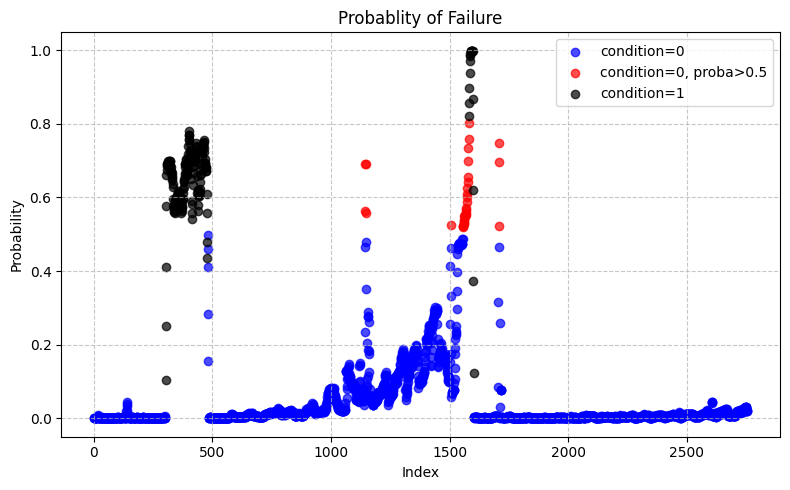

In [46]:
penalty, C_value, solver, max_iter = "l2", 0.1 , "saga", 250

aggregation_size, sliding_amount = 400,100

dataframe = df3

###########################################

treshold_probability = 0.5

aggregated_probabilities = agg_new_deneme(penalty, C_value, solver, max_iter,dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 15, 15, "yes", "yes", "no", "no", sliding_amount)

calculate_scores_log(aggregated_probabilities)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

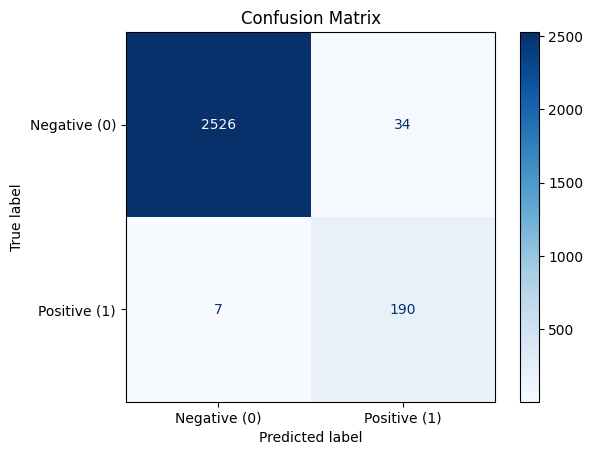

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2560
           1       0.85      0.96      0.90       197

    accuracy                           0.99      2757
   macro avg       0.92      0.98      0.95      2757
weighted avg       0.99      0.99      0.99      2757



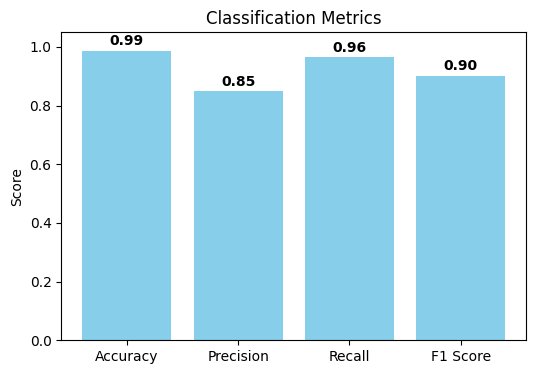

In [47]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt

# Tahmin sütunu oluştur
aggregated_probabilities['predicted'] = (aggregated_probabilities['proba'] >= 0.5).astype(int)

# Gerçek ve tahmin değerleri
y_true = aggregated_probabilities['condition']
y_pred = aggregated_probabilities['predicted']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative (0)", "Positive (1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Metrikleri hesapla
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Metrikleri yazdır
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=2, zero_division=0))

# Bar grafiği ile görselleştir
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

plt.figure(figsize=(6, 4))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0, 1.05)
plt.title("Classification Metrics")
plt.ylabel("Score")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()